In [14]:
#!pip install hmmlearn

%matplotlib inline
from hmmlearn import hmm
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import math
import scipy.stats as stats
import statsmodels.api as sm
#import gdown

In [31]:
ticker = "^GSPC"  #S&P 500 index symbol
data = yf.download(ticker, start="1950-03-01", end="2024-01-11", interval="1d")

data = data[data.columns[0:5]]
#data = data[:5348]
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close
Date,,,,,
1950-03-01,17.240000,17.240000,17.240000,17.240000,17.240000
1950-03-02,17.230000,17.230000,17.230000,17.230000,17.230000
1950-03-03,17.290001,17.290001,17.290001,17.290001,17.290001
1950-03-06,17.320000,17.320000,17.320000,17.320000,17.320000
1950-03-07,17.200001,17.200001,17.200001,17.200001,17.200001
...,...,...,...,...,...
2024-01-04,4697.419922,4726.779785,4687.529785,4688.680176,4688.680176
2024-01-05,4690.569824,4721.490234,4682.109863,4697.240234,4697.240234
2024-01-08,4703.700195,4764.540039,4699.819824,4763.540039,4763.540039


In [23]:
# Resample the data to monthly frequency
obs = data.resample('M').agg({'Open': 'first','High': 'max','Low': 'min','Close': 'last'})

# Reset the index to have 'Date' as a column again
obs = obs.reset_index()

# Print the monthly data
print(obs)

data = obs[:162]
print(data)

          Date       Open        High        Low       Close
0   1950-03-31  17.240000   17.559999  17.070000   17.290001
1   1950-04-30  17.530001   18.049999  17.530001   17.959999
2   1950-05-31  18.219999   18.780001  18.110001   18.780001
3   1950-06-30  18.770000   19.400000  17.440001   17.690001
4   1950-07-31  17.639999   17.910000  16.680000   17.840000
..         ...        ...         ...        ...         ...
252 1971-03-31   0.000000  102.029999  96.110001  100.309998
253 1971-04-30   0.000000  105.599998  99.629997  103.949997
254 1971-05-31   0.000000  104.419998  98.680000   99.629997
255 1971-06-30   0.000000  102.070000  96.919998   98.699997
256 1971-07-31   0.000000  101.519997  99.070000   99.500000

[257 rows x 5 columns]
          Date       Open       High        Low      Close
0   1950-03-31  17.240000  17.559999  17.070000  17.290001
1   1950-04-30  17.530001  18.049999  17.530001  17.959999
2   1950-05-31  18.219999  18.780001  18.110001  18.780001
3   1950

In [25]:
# Remove any rows with missing values
obs = obs.dropna()

# Select the first four columns as observations
obs = obs[obs.columns[1:5]]
# Set the number of observations to consider for each iteration
T = 96

# Initialize empty lists to store the evaluation criteria results
AIC, BIC, HQC, CAIC = [], [], [], []

# Iterate over different number of components for the HMM model
for n in range(2, 7):
    # Initialize empty lists to store the evaluation criteria values for each iteration
    a, b, c, d = [], [], [], []

    # Flag to check if it is the first iteration
    first_time = True

    # Iterate over the data with a sliding window of size T
    for i in range(0, T):
        # Define the HMM model
        if first_time:
            # For the first iteration, create a new model
            model = hmm.GaussianHMM(n_components=n, n_iter=100)
            first_time = False
        else:
            # For subsequent iterations, create a new model and initialize its parameters
            old_model = model
            model = hmm.GaussianHMM(n_components=n, init_params="c", n_iter=100)
            model.startprob_ = old_model.startprob_
            model.transmat_ = old_model.transmat_
            model.means_ = old_model.means_

        # Train the model using the Baum-Welch algorithm
        model.fit(obs[i:i+T])

        # Perform the forward algorithm to compute log-likelihoods and forward probabilities
        log_likelihoods, fwd = model.score_samples(obs[i:i+T])

        # Calculate the number of parameters for the model
        k = n**2 + 2*n - 1

        # Calculate AIC (Akaike Information Criterion)
        aic = -2 * log_likelihoods + 2 * k

        # Calculate BIC (Bayesian Information Criterion)
        bic = -2 * log_likelihoods + k * np.log(4 * T)

        # Calculate HQC (Hannan-Quinn Criterion)
        hqc = -2 * log_likelihoods + k * (np.log(np.log(4 * T)))

        # Calculate CAIC (Consistent Akaike Information Criterion)
        caic = -2 * log_likelihoods + k * (np.log(4 * T) + 1)

        # Append the evaluation criteria values to the corresponding lists
        a.append(aic)
        b.append(bic)
        c.append(hqc)
        d.append(caic)

    # Append the evaluation criteria lists for the current number of components to the main lists
    AIC.append(a)
    BIC.append(b)
    HQC.append(c)
    CAIC.append(d)

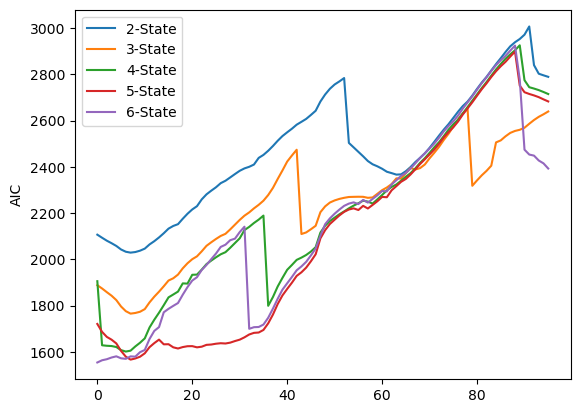

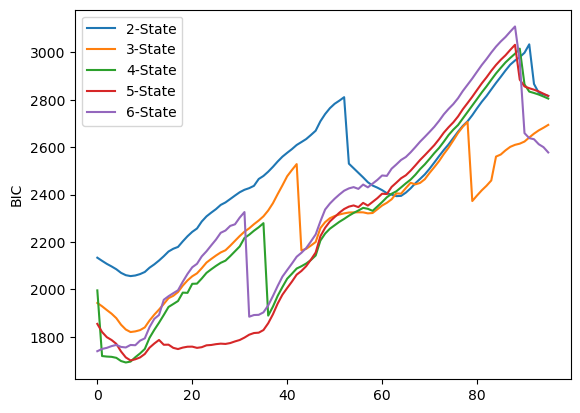

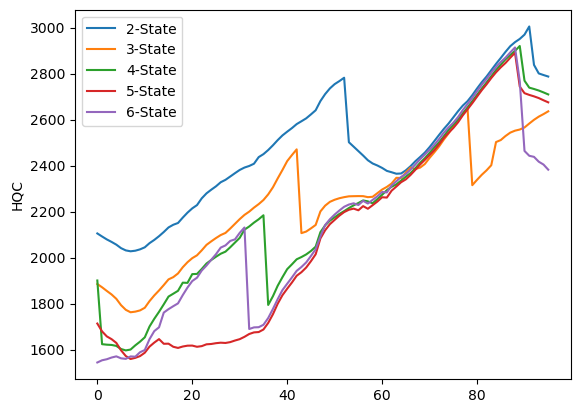

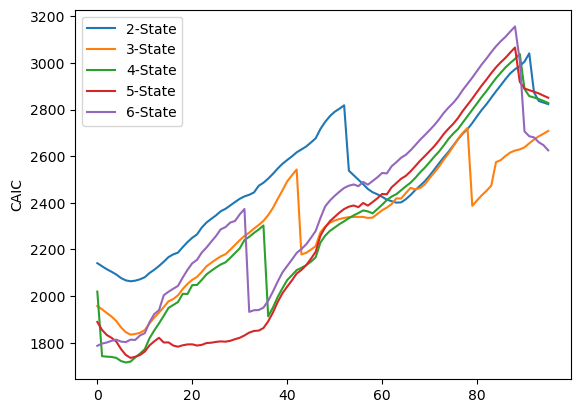

In [27]:
# Plot AIC values for different numbers of components
for i in range(0, 5):
    plt.plot(AIC[i], label=f"{i+2}-State")
plt.ylabel("AIC")

plt.legend()
plt.show()

# Plot BIC values for different numbers of components
for i in range(0, 5):
    plt.plot(BIC[i], label=f"{i+2}-State")
plt.ylabel("BIC")
plt.legend()
plt.show()

# Plot HQC values for different numbers of components
for i in range(0, 5):
    plt.plot(HQC[i], label=f"{i+2}-State")
plt.ylabel("HQC")
plt.legend()
plt.show()

# Plot CAIC values for different numbers of components
for i in range(0, 5):
    plt.plot(CAIC[i], label=f"{i+2}-State")
plt.ylabel("CAIC")
plt.legend()
plt.show()

T=  162
HMM Prices: 
[71.69999694824219, 71.45999145507812, 75.44000244140625, 74.66000366210938, 72.99999237060547, 78.04000091552734, 80.08000183105469, 79.76000213623047, 79.2199935913086, 80.6100082397461, 80.20000457763672, 84.52999877929688, 79.4800033569336, 83.5, 85.30000305175781, 82.98999786376953, 83.75, 90.79000091552734, 88.69999694824219, 87.43000030517578, 90.11000061035156, 92.7199935913086, 80.88999938964844, 83.33000183105469, 88.29999542236328, 87.16999816894531, 91.29000091552734, 90.8499984741211, 90.94000244140625, 90.5999984741211, 93.20999908447266, 92.18000030517578, 90.29999542236328, 84.73999786376953, 83.5999984741211, 77.0999984741211, 76.55999755859375, 80.19999694824219, 80.44999694824219, 80.33000183105469, 86.61000061035156, 86.77999877929688, 86.94999694824219, 94.01000213623047, 89.08000183105469, 90.63999938964844, 90.80999755859375, 98.56000518798828, 97.45000457763672, 100.52000427246094, 89.89000701904297, 90.59000396728516, 99.87999725341797, 88.

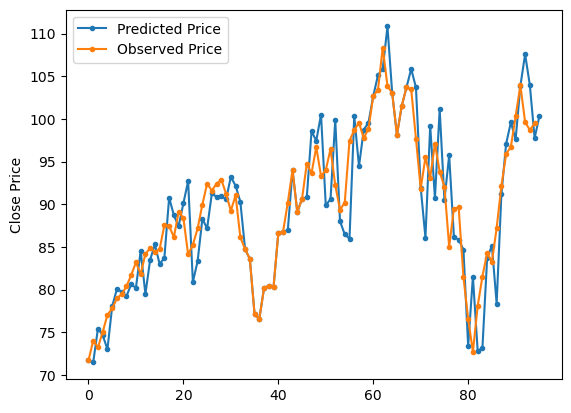

In [29]:
data = data[data.columns[1:5]]
obs = obs[obs.columns[1:5]]
# Calculate number of rows and set training window
T = data.shape[0]
print("T= ", T)

# Define the size of the training window
d = 96
D = 96
hmm_price = []

temp_T = T
first_time = True

# Sliding window approach to predict future prices
while T < temp_T + d:

    # Train HMM on data from T-D+1 to T
    train_data = obs.iloc[T-D:T]
    train_data = train_data.dropna()

    # Set the random seed
    np.random.seed(123)

    if(first_time):
      first_time = False
      model = hmm.GaussianHMM(n_components=5)
    else:
      old_model= model
      model = hmm.GaussianHMM(n_components=5, init_params="c")
      model.startprob_ = old_model.startprob_
      model.transmat_ = old_model.transmat_
      model.means_ = old_model.means_

    model.fit(train_data)

    # Calculate original likelihood
    original_likelihood = model.score(train_data)

    # Loop to find new likelihood
    t=T
    min_diff = float('inf')
    min_t = T
    min_likelihood = original_likelihood
    while t-D>  0:
        t = t-1

        train_data = obs.iloc[t-D:t]
        new_likelihood = model.score(train_data)
        if (abs(new_likelihood - original_likelihood))< min_diff:  # Threshold for comparison by choosing that new_likelihood which is minimum
            min_diff = abs(new_likelihood - original_likelihood)
            min_t = t
            min_likelihood = new_likelihood

    # Calculate the predicted close price
    close_price = obs['Close'][T-1] + ((obs['Close'][min_t + 1] - obs['Close'][min_t]) * np.sign(original_likelihood - min_likelihood))

    hmm_price.append(close_price)
    T=T+1

# Print the calculated prices
print("HMM Prices: ")
print(hmm_price)

# Plot the predicted and observed prices
close = []
truncated_obs = obs.iloc[T-d:T]

for i in truncated_obs['Close']:
  close.append(i)

plt.plot(hmm_price,marker='.', label = "Predicted Price")
plt.plot(close,marker = '.', label= "Observed Price")
plt.ylabel("Close Price")
plt.legend()
plt.show()